In [1]:
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 769 (items) x 256 (major_axis) x 201 (minor_axis)
Items axis: 0 to 768
Major_axis axis: 0 to 255
Minor_axis axis: 0 to 200

In [3]:
FREQ = 250 # Hz
ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]

def plot_electrode(x):
    plt.plot(np.linspace(-200,600,201), x, alpha=0.5)

def plot_welch(x):
    f, power = signal.welch(x, fs=FREQ, nperseg=len(x), nfft=2048)
    plt.plot(f, power, '-')
    #plt.yscale('log')
    plt.xlim(-2,45)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [V^2/Hz]')

# Un solo Epoch

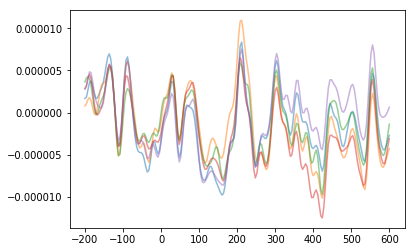

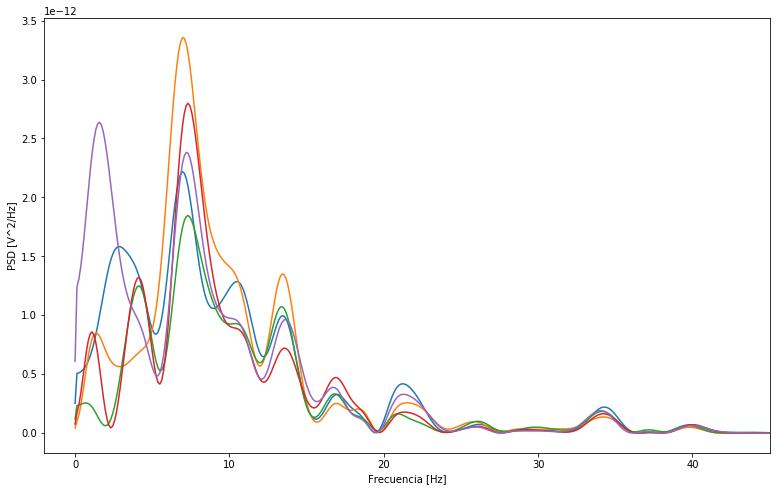

In [4]:
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(panel[0,electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(panel[0,electrode])
plt.show()

# Promedio entre Epochs

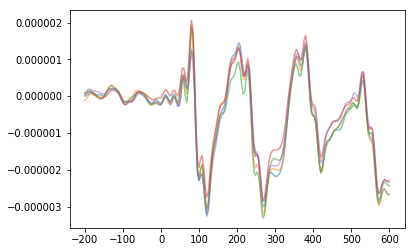

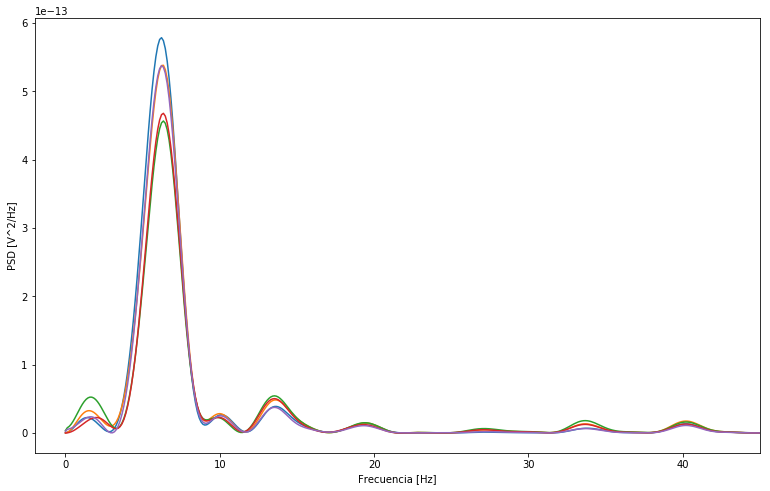

In [5]:
def mean_between_epochs(panel):
    return panel.mean(0)

mean_df = mean_between_epochs(panel).T

for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(mean_df[electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(mean_df[electrode])
plt.show()


In [6]:
def mean_between_electrodes(panel, electrodes):
    return panel[:,electrodes].mean(1)

def fourier_per_epoch(panel, electrodes):
    samples_per_epoch = mean_between_electrodes(panel, electrodes)
    relevant_frecuencies = 38
    res = []
    for _, samples in samples_per_epoch.iteritems():
        frequencies, powers = signal.welch(samples, FREQ, nperseg=len(samples))
        res.append(powers[:relevant_frecuencies])
    return np.asarray(res), frequencies[:relevant_frecuencies]

spectrogram_alpha, frequencies_alpha = fourier_per_epoch(panel, ALPHA_RELEVANT_ELECTRODES)
#spectrogram_all, frequencies_all = fourier_per_epoch(panel, range(256))

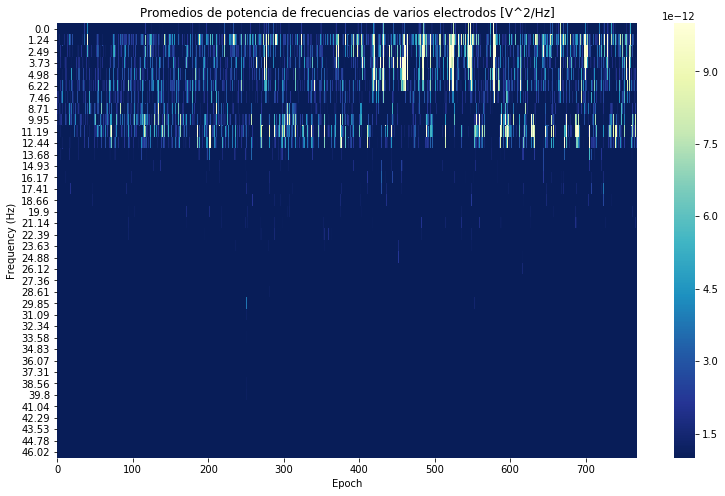

In [7]:
def plot_spectrogram(spectrogram, frequencies):
    spectrogram = spectrogram.T
    plt.figure(figsize=(13, 8))
    ax = sns.heatmap(spectrogram, 
                     xticklabels=100, yticklabels=frequencies.round(2), 
                     #cbar_kws=('PSD [V**2/Hz]'),
                     vmin=0.1e-11, vmax=1e-11, 
                     #center=1.5e-11,
                     cmap='YlGnBu_r'
                     )
    plt.title('Promedios de potencia de frecuencias de varios electrodos [V^2/Hz]')
    plt.xlabel('Epoch')
    plt.ylabel('Frequency (Hz)')
    plt.show()

plot_spectrogram(spectrogram_alpha, frequencies_alpha)

# Categorizamos las frecuencias según su tipo

In [8]:
def mean_power_per_frequency_range(panel):
    mean_samples = panel.mean(0).mean(0)

    def belongs(frequency_range, frequency):
        return frequency_range[0] <= frequency < frequency_range[1]

    frequencies, power = signal.welch(mean_samples, fs=FREQ, nperseg=len(mean_samples), nfft=2048)
    #plt.plot(frequencies, power)
    #plt.show()
    limits = {'delta': (0,4), 'tita': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30, 45)}
    values_by_range = {'delta':[], 'tita':[], 'alpha':[], 'beta':[], 'gamma':[]}

    for f, p in zip(frequencies, power):
        for key, limit in limits.items():
            if belongs(limit, f):
                values_by_range[key].append(p)

    return {key: np.mean(value) for key, value in values_by_range.items()}

In [10]:
import gc
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]

powers_per_frequency_range_S = []
df = {}
for filename in onlyfiles:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    df[filename] = mean
    powers_per_frequency_range_S.append(mean)
    del mat
    del panel
    gc.collect()
pd.DataFrame(df)

,S01.mat,S02.mat,S03.mat,S04.mat,S05.mat,S06.mat,S07.mat,S08.mat,S09.mat,S10.mat
alpha,1.018124e-18,1.490140e-18,3.298416e-18,3.461662e-18,4.216208e-19,2.214408e-18,3.606037e-18,2.307048e-17,2.336278e-15,1.288334e-18
beta,1.164993e-19,6.150669e-19,1.714577e-19,9.176014e-19,6.058410e-20,5.906103e-19,1.400770e-18,1.853513e-17,7.789290e-16,1.513935e-18
delta,1.758339e-17,4.480592e-18,4.069123e-18,9.619497e-17,2.192465e-18,2.657606e-18,9.885603e-16,2.531939e-16,9.199016e-15,2.850883e-17
gamma,4.287459e-20,6.511922e-20,2.125357e-20,4.421508e-19,5.533112e-21,1.763434e-19,4.491292e-19,3.741905e-18,1.790973e-16,7.233118e-19
tita,3.821427e-18,2.470559e-18,9.899706e-18,9.542269e-18,5.981990e-18,6.876186e-18,7.334120e-18,1.828888e-16,7.275962e-16,1.136760e-17


In [11]:
onlyfiles = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
powers_per_frequency_range_P = []
df = {}
for filename in onlyfiles:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    df[filename] = mean
    powers_per_frequency_range_P.append(mean)
    del mat
    del panel
    gc.collect()
pd.DataFrame(df)

,P01.mat,P02.mat,P03.mat,P04.mat,P05.mat,P06.mat,P07.mat,P08.mat,P09.mat,P10.mat
alpha,8.238155e-18,7.786535e-19,3.917995e-18,1.920496e-19,4.673913e-17,5.225773e-20,8.938046e-18,4.201974e-18,2.914532e-16,3.499935e-20
beta,1.398973e-18,5.133783e-19,7.829581e-19,2.822063e-20,1.468661e-17,1.921528e-20,3.662577e-18,9.701653e-19,5.726377e-16,1.000993e-20
delta,1.809511e-17,4.427606e-17,8.507534e-17,6.441223e-18,6.488753e-17,2.297620e-18,5.014396e-17,3.005454e-16,8.859136e-15,3.253238e-18
gamma,6.974721e-19,2.450367e-19,3.101347e-19,6.414734e-21,5.699224e-18,5.531395e-21,2.371531e-19,1.516745e-19,6.275231e-16,6.027917e-21
tita,7.506528e-17,2.009000e-17,6.656485e-18,3.035517e-18,3.245357e-16,4.929869e-19,8.393983e-17,1.213798e-16,2.482017e-15,2.987604e-19


(20, 5)


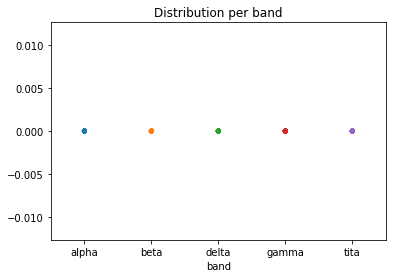

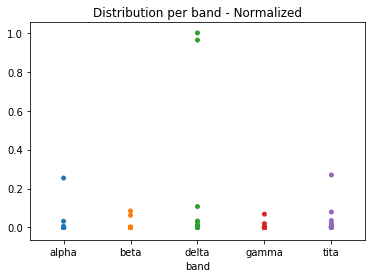

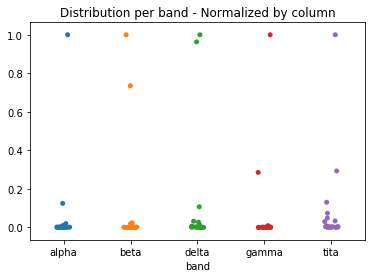

In [12]:
dS = pd.DataFrame(powers_per_frequency_range_S)
dP = pd.DataFrame(powers_per_frequency_range_P)
data = pd.concat([dS,dP])
print(data.shape)

data = data.rename_axis("patient", axis=0)
data = data.rename_axis("band", axis=1)


ax = sns.stripplot(data=data, 
                   vmin=data.min().min(), 
                   vmax=data.max().max()
                  )
#ax.set_yscale('log')
plt.title('Distribution per band')
plt.show()

df = data
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.stripplot(data=df_norm, 
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()


df = data
df_norm = ( (df - df.min() ) / (df.max() - df.min()) )
ax = sns.stripplot(data=df_norm,
                   jitter=True,
                   vmin=df_norm.min().min(), 
                   vmax=df_norm.max().max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized by column')
plt.show()

## Análisis de información (intra-electrodo)

In [13]:
# a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

import scipy

def compute_entropy(series):
    histogram, bins = np.histogram(series, 'fd') # Freedman-Diaconis
    probabilities = [1/frecuency if frecuency != 0 else 0 for frecuency in histogram]
    return scipy.stats.entropy(probabilities)

EPOCH = 0      # totally arbitrary
ELECTRODE = 8  # idem

onlyfiles = [f for f in listdir('data') if (f.endswith('.mat'))]
for filename in onlyfiles:
    print(filename)
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    electrode_data = panel[EPOCH, ELECTRODE]
    entropy = compute_entropy(electrode_data)
    mean_per_channel = 0 # TODO: A qué se refiere con "la media entre canales y epochs para cada sujeto"?
    mean_per_epoch = 0 # TODO: idem
    print("Entropy: {}, Mean per channel: {}, Mean per epoch: {}".format(entropy, mean_per_channel, mean_per_epoch))
    
    del mat
    del panel
    gc.collect()
    
# TODO: qué es exactamente lo que hay que graficar?

P01.mat
Entropy: 2.196024206956227, Mean per channel: 0, Mean per epoch: 0
P02.mat
Entropy: 2.0050113868638952, Mean per channel: 0, Mean per epoch: 0
P03.mat
Entropy: 1.8846634771958855, Mean per channel: 0, Mean per epoch: 0
P04.mat
Entropy: 1.9151975861226682, Mean per channel: 0, Mean per epoch: 0
P05.mat
Entropy: 2.2458212521883967, Mean per channel: 0, Mean per epoch: 0
P06.mat
Entropy: 2.56717888169027, Mean per channel: 0, Mean per epoch: 0
P07.mat
Entropy: 1.8957694374050864, Mean per channel: 0, Mean per epoch: 0
P08.mat
Entropy: 1.8907909204767517, Mean per channel: 0, Mean per epoch: 0
P09.mat
Entropy: 2.163868044009564, Mean per channel: 0, Mean per epoch: 0
P10.mat
Entropy: 2.018267220916983, Mean per channel: 0, Mean per epoch: 0
S01.mat
Entropy: 1.892217279883779, Mean per channel: 0, Mean per epoch: 0
S02.mat
Entropy: 1.7598679664760164, Mean per channel: 0, Mean per epoch: 0
S03.mat
Entropy: 1.8728564447131915, Mean per channel: 0, Mean per epoch: 0
S04.mat
Entropy: 2

## Análisis de información (inter-electrodo)

In [14]:
import itertools
from functools import reduce

def joint_entropy(*X): # from https://blog.biolab.si/2012/06/15/computing-joint-entropy-in-python/
    return np.sum(-p * np.log2(p) if p > 0 else 0 for p in
        (np.mean(reduce(np.logical_and, (predictions == c for predictions, c in zip(X, classes))))
            for classes in itertools.product(*[set(x) for x in X])))
        
EPOCH = 0
ELECTRODES = (8,10,11)
for filename in onlyfiles:
    print(filename)
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    electrode_data = (column.tolist() for _, column in panel[EPOCH, ELECTRODES].iteritems())
    entropy = 0 # joint_entropy(*electrode_data)
    print("Joint entropy: {}".format(entropy))
    
    del mat
    del panel
    gc.collect()

P01.mat
Joint entropy: 0
P02.mat
Joint entropy: 0
P03.mat
Joint entropy: 0
P04.mat
Joint entropy: 0
P05.mat
Joint entropy: 0
P06.mat
Joint entropy: 0
P07.mat
Joint entropy: 0
P08.mat
Joint entropy: 0
P09.mat
Joint entropy: 0
P10.mat
Joint entropy: 0
S01.mat
Joint entropy: 0
S02.mat
Joint entropy: 0
S03.mat
Joint entropy: 0
S04.mat
Joint entropy: 0
S05.mat
Joint entropy: 0
S06.mat
Joint entropy: 0
S07.mat
Joint entropy: 0
S08.mat
Joint entropy: 0
S09.mat
Joint entropy: 0
S10.mat
Joint entropy: 0
